# CNN 모델 구현

In [ ]:
# 이 셀을 돌리기 전에 GPU 연결을 확인하세요!

In [ ]:
# Google Drive 접근 = 구글 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  dir 불러오기
train_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/train'
validation_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/valid'

## EfficientNet

In [ ]:
# EfficientNet을 설치부터 진행!
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
# 필요한 module import
import numpy as np
import matplotlib.pyplot as plt
import efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2

In [ ]:
IMAGE_SIZE = 150  # 이 이미지의 크기는 일반적으로 pretrained network을
                  # 어떤 종류를 사용하는냐에 따라서 결정되요!
BATCH_SIZE = 5


# 이미지 전처리에 대한 함수예요. 여기서는 resize만 처리할꺼예요!
def GeneratePreprocess(img):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
s    return img

### 방법 1) Augmentation 포함O --> ImageDataGenerator 생성

In [32]:
# Augmentation 포함해서 ImageDataGenerator를 객체 생성
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=GeneratePreprocess,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255,
                                        preprocessing_function=GeneratePreprocess)

In [33]:
# ImageDataGenerator 객체 세부 설정

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

Found 380 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


### 방법 2) Augmentation 포함 X --> ImageDataGenerator 생성



In [31]:
# Augmentation 포함하지 않은 ImageDataGenerator 객체 생성

train_datagen = ImageDataGenerator(rescale=1/255,
                                   preprocessing_function=GeneratePreprocess) # 0 or 1의 값이 나올 수 있도록 255로 나누어 준다
validation_datagen=ImageDataGenerator(rescale=1/255,
                                      preprocessing_function=GeneratePreprocess)

In [ ]:
# ImageDataGenerator 객체 세부 설정

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

### pretrained Network (EfficientNet) Loading

In [ ]:
# Pretrained Network Loading

pretrained_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)
)

71892840/71892840 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.trainable = False

pretrained_model.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 75, 75, 48)           1296      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 75, 75, 48)           192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 75, 75, 48)           0         ['stem_bn[0][0]'

In [34]:
# Model 구현
model = Sequential()

model.add(pretrained_model)

model.add(Flatten(input_shape=(5*5*1792,)))
model.add(Dense(units=3,
                activation='softmax'))

es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=76, # 380/5 = 76
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=12) #60/5 = 12

model.save('./infantface_IDG_cnn_Eff_model.h5')

Epoch 1/100
76/76 [==============================] - 17s 94ms/step - loss: 1.0804 - accuracy: 0.4895 - val_loss: 0.7419 - val_accuracy: 0.7333
Epoch 2/100
76/76 [==============================] - 5s 62ms/step - loss: 0.7871 - accuracy: 0.6632 - val_loss: 0.8712 - val_accuracy: 0.5667
Epoch 3/100
76/76 [==============================] - 5s 61ms/step - loss: 0.7722 - accuracy: 0.6658 - val_loss: 0.7393 - val_accuracy: 0.6000
Epoch 4/100
76/76 [==============================] - 5s 62ms/step - loss: 0.6240 - accuracy: 0.7316 - val_loss: 0.8299 - val_accuracy: 0.6667
Epoch 5/100
76/76 [==============================] - 5s 60ms/step - loss: 0.5344 - accuracy: 0.7763 - val_loss: 0.7024 - val_accuracy: 0.7000
Epoch 6/100
76/76 [==============================] - 5s 62ms/step - loss: 0.5537 - accuracy: 0.7658 - val_loss: 0.4502 - val_accuracy: 0.8333
Epoch 7/100
76/76 [==============================] - 5s 63ms/step - loss: 0.5360 - accuracy: 0.7921 - val_loss: 0.3604 - val_accuracy: 0.8833
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


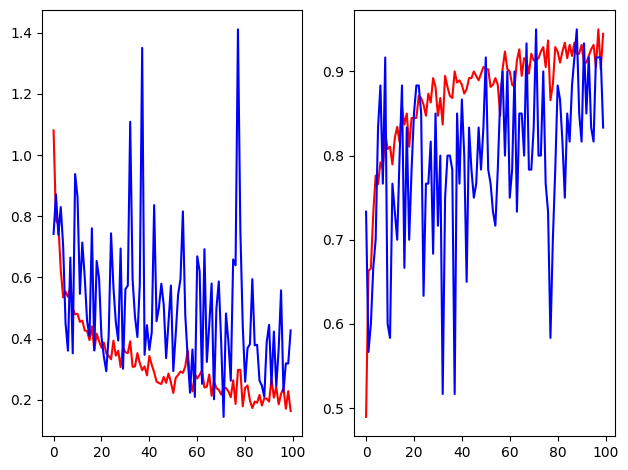

In [35]:
# 결과 그래프를 그려보아요!

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

# Test

In [36]:
# 테스트에 필요한 module import
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [49]:
# 저장된 모델 파일의 경로
# saved_model_path = '/content/saved된 모델이름.h5' # model을 학습시킬 때 마지막에 model.save('저장된 모델 이름')코드 안에 있는 모델 이름을 적어주시면 됩니다
saved_model_path = '/content/infantface_IDG_cnn_Eff_model.h5'

# 테스트할 이미지 경로 설정
test_image_path = '/content/drive/MyDrive/KOSA3/project/data/baby6.png'

# 모델 로드
loaded_model = load_model(saved_model_path)

# 이미지 불러오기 및 전처리
img = image.load_img(test_image_path, target_size=(150, 150)) # 위에서 우리가 저장한 target_size와 같은 크기로 주시면 돼요!
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # 경우에 따라 axis값이 달라집니다
img_array = preprocess_input(img_array)

In [50]:
# 모델 예측
predictions = loaded_model.predict(img_array)

# 예측 결과 해석 및 출력
class_indices = np.argmax(predictions, axis=1)

# 각 클래스의 인덱스에 따른 레이블 설정 (positive, neutral, negative)
class_labels = ['positive', 'neutral', 'negative']
predicted_label = class_labels[class_indices[0]]

print(f"Predicted Class: {predicted_label}")

1/1 [==============================] - 2s 2s/step
Predicted Class: neutral
